In [1]:
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if os.path.isdir(os.path.join(PROJECT_ROOT, "src")):
    sys.path.insert(0, PROJECT_ROOT)
else:
    # fallback: try current directory
    sys.path.insert(0, os.getcwd())

import matplotlib.pyplot as plt
import copy
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D

from src.solver_utils import solve_precond
from src.basis.basis import BasisHandler
from src.matrix_generation import assemble_matrix_integral_1d
from src.primitives import Primitives_MinimalSupport
from src.operators import differentiate

In [2]:
#Benchamrk solution
u_exact = lambda x, y: np.sin(np.pi * x) * np.sin(np.pi * y)
u_exact_x = lambda x, y: np.pi * np.cos(np.pi * x) * np.sin(np.pi * y)
u_exact_y = lambda x, y: np.pi * np.sin(np.pi * x) * np.cos(np.pi * y)
f_rhs = lambda x, y: 2 * (np.pi ** 2) * np.sin(np.pi * x) * np.sin(np.pi * y)

In [3]:
#Basis construction
primitives = Primitives_MinimalSupport()
basis_handler = BasisHandler(primitives=primitives, dimension=1)

In [4]:
def test_2d(
    levels,
    u_exact,
    u_exact_x,
    u_exact_y,
    f_rhs,
    xs_ref=np.linspace(0, 1, 100),
    ys_ref=np.linspace(0, 1, 100),
):
    """
    Run convergence study for the 2D Poisson wavelet–Galerkin solver (isotropic tensor).
    Uses only 1D bases and Kronecker structure (like the 1D test).
    """
    X, Y = np.meshgrid(xs_ref, ys_ref, indexing="ij")
    u_ref   = u_exact(X, Y)
    u_ref_x = u_exact_x(X, Y)
    u_ref_y = u_exact_y(X, Y)

    errors_L2, errors_H1, Ns, Ss, U_solutions = [], [], [], [], []

    for Jmax in levels:
        print(f"\n=== Testing level {Jmax} ===")

        # ---- build 1D bases ----
        basis_handler.build_basis(J_Max=Jmax, comp_call=True, J_0=2)
        basis_handler_diff = copy.deepcopy(basis_handler)
        basis_handler_diff.apply(differentiate, comp_call=True, axis=0)  # 1D derivative

        # ---- assemble 1D and 2D matrices ----
        M1 = assemble_matrix_integral_1d(
            basis_handler.flatten(), basis_handler.flatten()
        )
        S1 = assemble_matrix_integral_1d(
            basis_handler_diff.flatten(), basis_handler_diff.flatten()
        )
        from src.matrix_generation import extend_stiffness
        S2 = extend_stiffness(M1, S1, 2)
        Ss.append(S2)

        # ---- project RHS (2D Gauss from the 1D basis) and solve ----
        b2 = basis_handler.project_rhs_2d_gauss(f_rhs)
        coeffs = solve_precond(S2, b2)  # length N^2
        N1 = len(basis_handler.flatten())
        C = coeffs.reshape(N1, N1)

        # ---- evaluate Φ and Φ' on reference grids (1D only) ----
        Phix    = basis_handler._eval_basis_on_nodes(basis_handler.flatten(), xs_ref)
        Phiy    = basis_handler._eval_basis_on_nodes(basis_handler.flatten(), ys_ref)
        Phix_dx = basis_handler._eval_basis_on_nodes(basis_handler_diff.flatten(), xs_ref)
        Phiy_dy = basis_handler._eval_basis_on_nodes(basis_handler_diff.flatten(), ys_ref)

        # ---- tensor evaluations ----
        u_num   = Phix    @ C @ Phiy.T
        u_num_x = Phix_dx @ C @ Phiy.T
        u_num_y = Phix    @ C @ Phiy_dy.T

        U_solutions.append(u_num)

        # ---- errors ----
        err_L2 = np.sqrt(np.trapezoid(np.trapezoid((u_num - u_ref)**2, ys_ref, axis=1), xs_ref))
        grad_err = (u_num_x - u_ref_x)**2 + (u_num_y - u_ref_y)**2
        err_H1 = np.sqrt(np.trapezoid(np.trapezoid(grad_err, ys_ref, axis=1), xs_ref))

        print(f"L2 error = {err_L2:.3e},   H1 error = {err_H1:.3e}")

        errors_L2.append(err_L2)
        errors_H1.append(err_H1)
        Ns.append(N1**2)

    return errors_H1, errors_L2, Ss, Ns, U_solutions
       

In [5]:
levels=[2,3,4,5,6]
errors_H1, errors_L2, Ss, Ns, U_solutions=test_2d(levels,u_exact,u_exact_x,u_exact_y,f_rhs,)


=== Testing level 2 ===
3
L2 error = 2.568e-04,   H1 error = 1.306e-02

=== Testing level 3 ===
4
L2 error = 3.111e-05,   H1 error = 3.217e-03

=== Testing level 4 ===


/Users/rados/Projects_personal/Galerkin_solver3/src/matrix_generation.py:30: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val, _ = quad(lambda x: fi(x) * fj(x), a, b, epsabs=1e-12, epsrel=1e-12)


5
L2 error = 3.858e-06,   H1 error = 8.009e-04

=== Testing level 5 ===
6
L2 error = 4.813e-07,   H1 error = 2.008e-04

=== Testing level 6 ===
7
L2 error = 6.013e-08,   H1 error = 4.998e-05


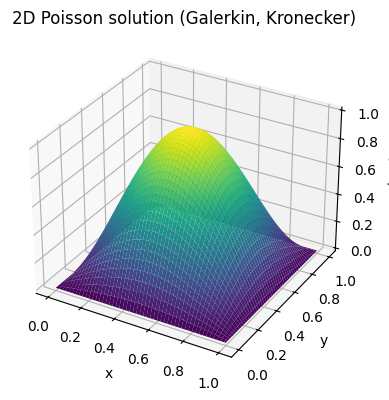

In [6]:
U_num=U_solutions[-1]
xs = np.linspace(0, 1, U_num.shape[0])
ys = np.linspace(0, 1, U_num.shape[1])
X, Y = np.meshgrid(xs, ys, indexing="ij")

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, U_num, cmap="viridis", linewidth=0, antialiased=True)
ax.set_title("2D Poisson solution (Galerkin, Kronecker)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u(x,y)")
plt.tight_layout()
plt.show()



Matrix size: 1024 × 1024
Condition number (original):      4.945e+02
Condition number (preconditioned): 2.688e+01
Original (after preconditioning): 204160 nonzeros  (19.47% dense)
Thresholded (|S| ≥ 1e-06): 190780 nonzeros  (18.19% dense)


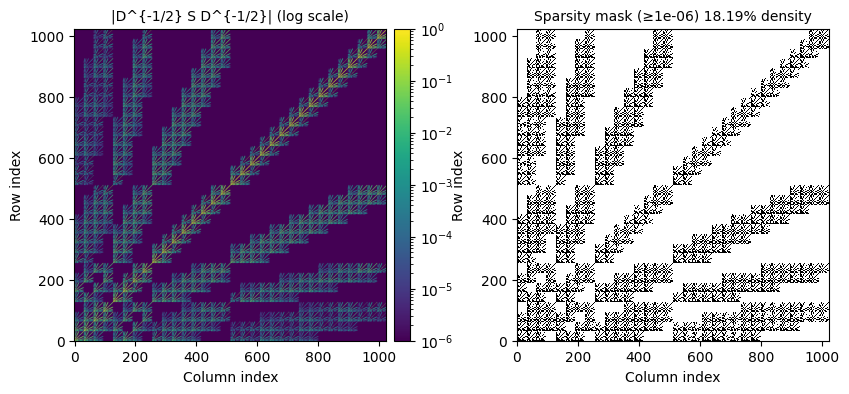

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# --- Take last (finest) stiffness matrix ---
S_last = Ss[2]

# --- Precondition the matrix (D^{-1/2} S D^{-1/2}) ---
D = np.diag(np.diag(S_last))
D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))
S_precond = D_inv_sqrt @ S_last @ D_inv_sqrt

# --- Compute condition numbers ---
cond_orig = np.linalg.cond(S_last)
cond_precond = np.linalg.cond(S_precond)

print(f"Matrix size: {S_last.shape[0]} × {S_last.shape[1]}")
print(f"Condition number (original):      {cond_orig:.3e}")
print(f"Condition number (preconditioned): {cond_precond:.3e}")

# --- Threshold and sparsity stats ---
threshold = 1e-6
S_abs = np.abs(S_precond)  # visualize preconditioned version
S_mask = (S_abs >= threshold).astype(float)

n_total = S_abs.size
n_nz_orig = np.count_nonzero(S_abs)
n_nz_mask = np.count_nonzero(S_mask)
ratio_orig = 100 * n_nz_orig / n_total
ratio_mask = 100 * n_nz_mask / n_total

print(f"Original (after preconditioning): {n_nz_orig} nonzeros  ({ratio_orig:.2f}% dense)")
print(f"Thresholded (|S| ≥ {threshold:g}): {n_nz_mask} nonzeros  ({ratio_mask:.2f}% dense)")

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# left: log-scaled preconditioned matrix
im0 = axes[0].imshow(
    S_abs + 1e-16,
    cmap="viridis",
    norm=LogNorm(vmin=np.max(S_abs) * 1e-6, vmax=np.max(S_abs)),
    origin="lower"
)
axes[0].set_title("|D^{-1/2} S D^{-1/2}| (log scale)", fontsize=10)
axes[0].set_xlabel("Column index")
axes[0].set_ylabel("Row index")
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.02)

# right: thresholded binary sparsity pattern
im1 = axes[1].imshow(S_mask, cmap="gray_r", origin="lower", interpolation="none")
axes[1].set_title(f"Sparsity mask (≥{threshold:g}) {ratio_mask:.2f}% density", fontsize=10)
axes[1].set_xlabel("Column index")
axes[1].set_ylabel("Row index")

# --- Adjust spacing to bring plots closer ---
plt.subplots_adjust(wspace=0.15, left=0.07, right=0.93, top=0.88, bottom=0.1)

plt.savefig("stiffness_poisson.png", dpi=300, bbox_inches="tight")
plt.show()

In [12]:


for S, J in zip(Ss, levels):
    # diagonal scaling
    # D = np.diag(np.diag(S))
    # D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))
    # S_precond = D_inv_sqrt @ S @ D_inv_sqrt

    # condition numbers
    # cond_orig = np.linalg.cond(S)
    # cond_pre = np.linalg.cond(S_precond)

    # print(f"Level J={J:<2d}:"
    #       f"cond(D^(-1/2) S D^(-1/2)) = {cond_pre:10.3e}")
    print(f"Level J={J:<2d}: nnz:{np.count_nonzero(S)} ")

Level J=2 : nnz:2704 
Level J=3 : nnz:26244 
Level J=4 : nnz:204160 
Level J=5 : nnz:1367960 
Level J=6 : nnz:8241052 


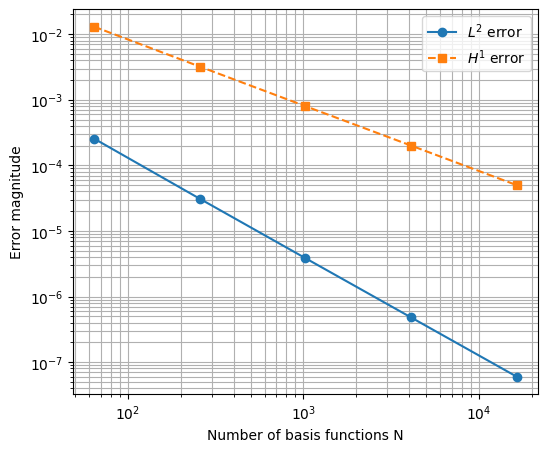

In [8]:
plt.figure(figsize=(6,5))
plt.loglog(Ns, errors_L2, 'o-', label=r'$L^2$ error')
plt.loglog(Ns, errors_H1, 's--', label=r'$H^1$ error')
plt.xlabel("Number of basis functions N")
plt.ylabel("Error magnitude")
plt.grid(True, which="both")
plt.legend()
plt.savefig("Poisson_convergence.png", dpi=300)
plt.show()